<a href="https://colab.research.google.com/github/zahra-sharifzadeh/Digital_Audio_Processing/blob/main/Implementing%20Band%20Energy%20Ratio%20from%20Scratch%20with%20Python/Implementing_Band_Energy_Ratio_from_Scratch_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

from pathlib import Path

import requests
# example source: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

  """Download a Zipped dataset from source and unzipe to destination."""
  data_path = Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping download.")

  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


    target_file = Path(source).name

    with open(data_path/target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    if remove_source:
      os.remove(data_path / target_file)

  return image_path

In [2]:
source_path = "https://github.com/zahra-sharifzadeh/Digital_Audio_Processing/raw/main/Extracting%20Spectrograms%20from%20Audio%20with%20Python/audio.zip"
image_path = download_data(source = source_path,
                  destination = "audio",
                  remove_source = True)

[INFO] Did not find data/audio directory, creating one...
[INFO] Downloading audio.zip from https://github.com/zahra-sharifzadeh/Digital_Audio_Processing/raw/main/Extracting%20Spectrograms%20from%20Audio%20with%20Python/audio.zip...
[INFO] Unzipping audio.zip data...


##Loading Audio

In [15]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [5]:
debussy_file = "/content/data/audio/audio/debussy.wav"
duke_file = "/content/data/audio/audio/duke.wav"
redhot_file = "/content/data/audio/audio/redhot.wav"

In [6]:
debussy, sr = librosa.load(debussy_file)
redhot, _ = librosa.load(redhot_file)
duke, _ = librosa.load(duke_file)


##Extract spectrogram

In [25]:
FRAME_SIZE = 2048
HOP_SIZE = 512

debussy_spec = librosa.stft(debussy, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
redhot_spec = librosa.stft(redhot, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
duke_spec = librosa.stft(duke, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

##Calculate Band Energy Ratio

In [26]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""

    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)


In [27]:
split_frequency_bin = calculate_split_frequency_bin(2000, 22050, 1025)
split_frequency_bin

185

In [28]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""

    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []

    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T

    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)

    return np.array(band_energy_ratio)

In [29]:
ber_debussy = band_energy_ratio(debussy_spec, 2000, sr)
ber_redhot = band_energy_ratio(redhot_spec, 2000, sr)
ber_duke = band_energy_ratio(duke_spec, 2000, sr)

In [30]:
len(ber_debussy)


1292

In [31]:
frames = range(len(ber_debussy))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

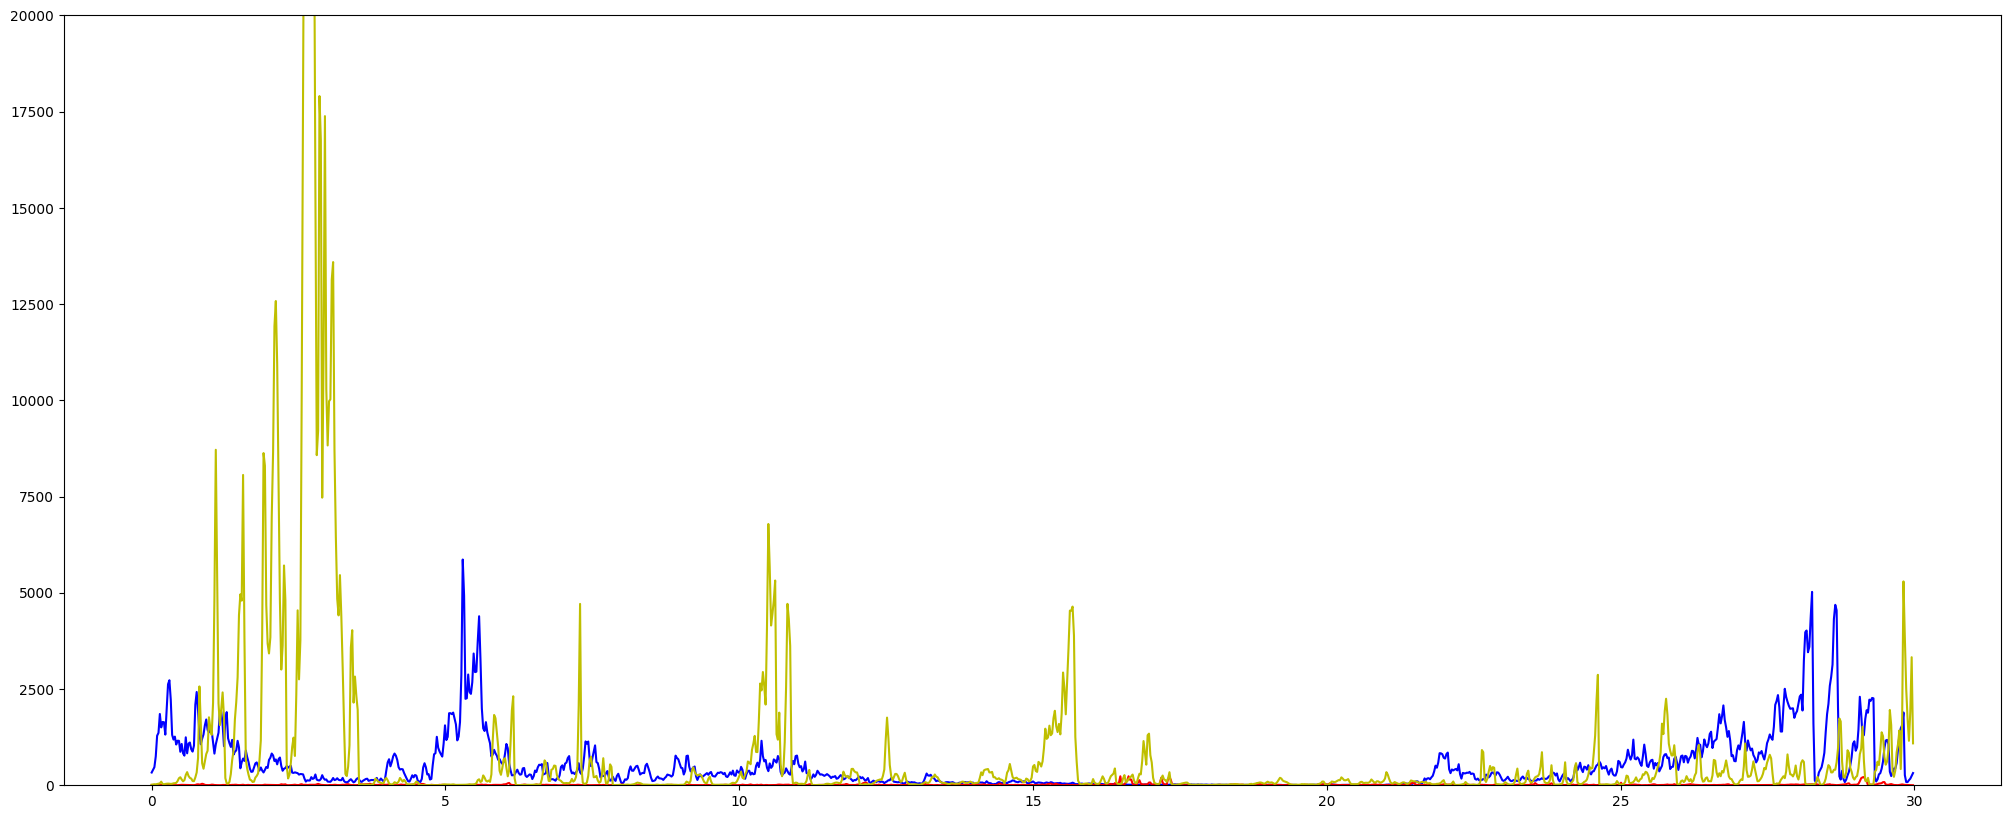

In [32]:
plt.figure(figsize=(25, 10))

plt.plot(t, ber_debussy, color="b")
plt.plot(t, ber_redhot, color="r")
plt.plot(t, ber_duke, color="y")
plt.ylim((0, 20000))
plt.show()